In [2]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior, hnn_noise_conn_prob_param_function,
                   load_posterior, simulator_hnn, get_dataset_psd, get_dataset_bandpower,
                   get_parameter_recovery, get_posterior_predictive_check)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123
rng = np.random.default_rng(rng_seed)

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

data_path = f'../data/noise_EI_connprob'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
extra_dict = posterior_metadata['extra_dict']
window_samples = extra_dict['window_samples'] 
theta_extra = sim_metadata['theta_extra']

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_noise_conn_prob_param_function,
                    network_model=net, theta_extra=theta_extra, tstop=tstop, return_objects=True)

In [3]:
dpl_orig, theta_orig = np.load(f'{data_path}/sbi_sims/dpl_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
dpl_orig = dpl_orig[:,window_samples[0]:window_samples[1]]

In [6]:
aperiodic_data = np.load(f'{data_path}/sbi_sims/aperiodic_sbi.npy')
aperiodic_data

array([[-4.62236321,  2.51266035],
       [-3.59860833,  2.92095875],
       [-3.87630335,  2.68949726],
       ...,
       [-4.76313867,  2.82704068],
       [-4.52147173,  2.62118876],
       [-3.74557428,  3.01396705]])

In [39]:
extra_dict['aperiodic_fname'] = f'{data_path}/sbi_sims/aperiodic_sbi.npy'

dpl_cond_list = [[4, 4, 4, 4], [5, 5, 5, 5]]
aperiodic_cond_list = [[-6, 1], [-6, 2], [-6, 3], [-6, 5]]
raw_data_type = {'dpl': {'train': dpl_orig, 'cond': dpl_cond_list},
                 'aperiodic_fname': {'train': extra_dict['aperiodic_fname'], 'cond': aperiodic_cond_list}}


In [40]:
posterior_state_dicts.keys()

dict_keys(['aperiodic', 'bandpower'])

In [41]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# Collect plotting data outside loop
scatter_data_list = list()
dist_data_list = list()
ppc_data_list = list()
theta_data_list = list()

# input_type_list = ['aperiodic', 'bandpower']
input_type_list = ['aperiodic']

for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list = list()
    x_orig = raw_data_type[input_dict['data_type']]['train']
    x_cond_list = raw_data_type[input_dict['data_type']]['cond']
    cond_name_list = [f'Cond{cond_idx}' for cond_idx in range(len(x_cond_list))]
    
    for x_cond, cond_name in zip(x_cond_list, cond_name_list):
        load_info = {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                     'x_cond': x_cond}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info['x_cond']))
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)

        df_temp = pd.DataFrame(df_dict)

        df_list.append(df_temp)
    df = pd.concat(df_list)
    
    scatter_data_list.append(df)
        
    # Parameter recovery
    #dist_array = get_parameter_recovery(theta_val, theta_grid, n_samples=nval_samples)
    #dist_data_list.append(dist_array)


    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    #ppc_array = get_posterior_predictive_check(x_val, x_grid, n_samples=nval_samples)
    #ppc_data_list.append(ppc_array)
    
    theta_data_list.append(theta_cond_transformed_list)


Conditioning Feature: aperiodic
 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples: 1126it [00:07, 158.97it/s]                         


 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples: 1076it [00:08, 133.92it/s]                         


 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples: 1396it [00:09, 146.25it/s]                        


 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples:   0%|          | 5/1000 [00:09<18:39,  1.13s/it]WARNING:root:Only 0.045% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    995 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1002it [03:43,  4.49it/s]                         


aperiodic


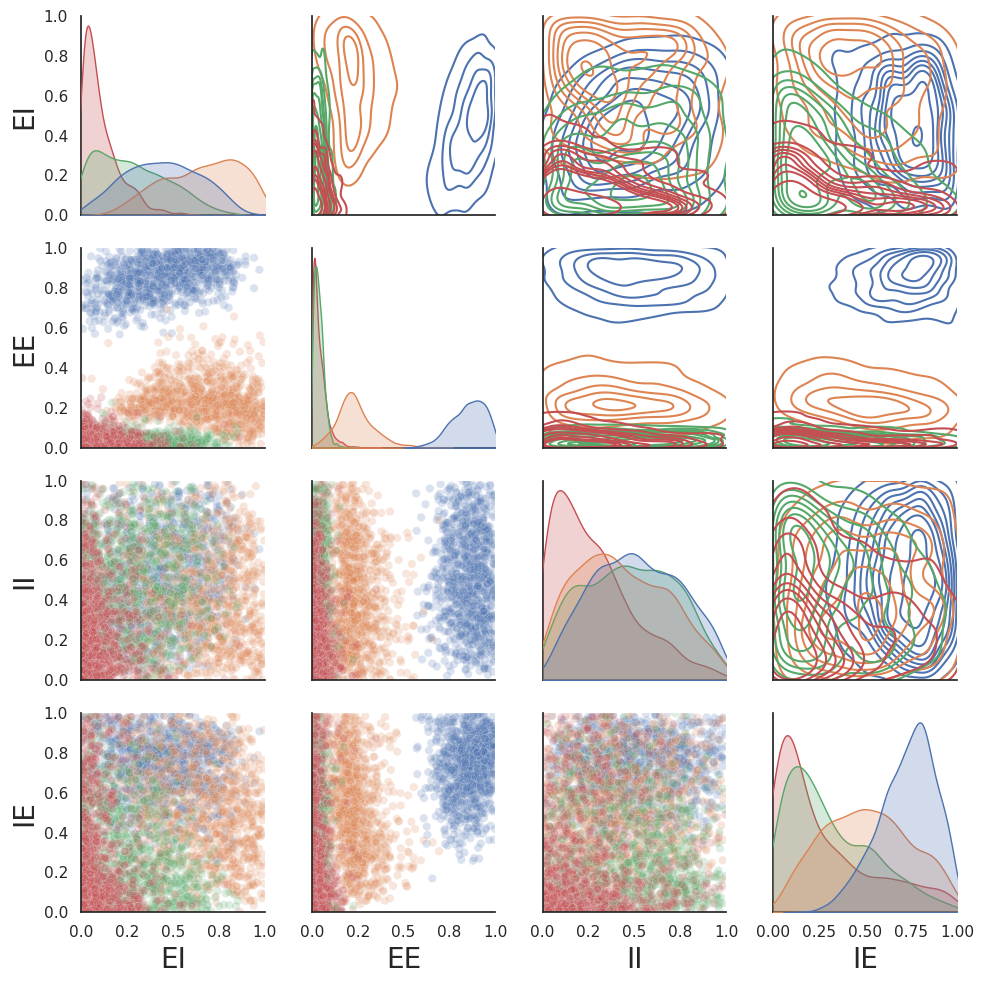

In [42]:
for feature_idx in range(len(input_type_list)):
    print(input_type_list[feature_idx])

    labelsize=20

    param_labels = ['EI', 'EE', 'II', 'IE']

    df = scatter_data_list[feature_idx]
    theta_cond_transformed_list = theta_data_list[feature_idx]

    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
    g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
    g.map_lower(sns.scatterplot, alpha=0.2)
    g.map_upper(sns.kdeplot, fill=False)
    g.map_diag(sns.kdeplot, fill=True)

    for idx in range(4):    
        # Add space to visuzalize groundtruth tick marks at top
        y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

        g.axes[idx, idx].set_xlim(all_bounds[idx])
        g.axes[idx, idx].set_ylim(all_bounds[idx])

        g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
        g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

    for idx1 in range(4):
        for idx2 in range(3):
            if g.axes[idx1, idx2] != None:
                g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tight_layout()
#plt.savefig('hnn_erp_posterior_compare.svg')